In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
root = '/Volumes/Festplatte/data-UA/'
data_path = root + 'data/'
president = 'trump'
cities = ['Birmingham', 'LA', 'London', 'NYC']
years = [str(year) for year in range(2018, 2023)] # ['2018', '2019', '2020', '2021', '2022']
boris_johnson_hashtags = ('BorisJohnson', 'UKPrimeMinister', 'ToryLeader', 'Boris')
donald_trump_hashtags = ('DonaldTrump', 'Trump2024', 'MakeAmericaGreatAgain', 'Trump')
president_hashtags = donald_trump_hashtags if president == 'trump' else boris_johnson_hashtags
def get_files(dir):
    """ get all files from a directory 
    that do not start with a '.'
    :param dir: String
    :return: List of Strings
    """
    return sorted([s for s in os.listdir(dir) if not s.startswith('.')])

In [3]:
# create columns
months = range(1, 13)
formatted_dates = [f'{year}-{month:02d}' for year in years for month in months]

In [4]:
def get_compound_sentiment(president):
    compound_sentiment = pd.DataFrame(index=cities, columns=formatted_dates)
    compound_col = 'Compound'
    for db_file in get_files(f'{data_path}{president}/'):
        # get date in the format YYYY-MM
        date_only = db_file[-11:-4]
        # load data
        data = pd.read_pickle(f'{data_path}{president}/{db_file}')
        # check if data has respective column
        assert compound_col in data.columns
        city = db_file.split('-')[0]
        # check if the city was extracted correctly
        assert city in cities
        # save the monthly compounded graded sentiment scoring in the compound_sentiment overview
        compound_sentiment.at[city, date_only] = data[compound_col].mean()
    # save data
    suffix = '_compound_sentiment.'
    compound_sentiment.to_pickle(f'{data_path}{president}{suffix}pkl')
    # convert compound sentiment pickle to csv
    data = pd.DataFrame(compound_sentiment)
    data.to_csv(f'{data_path}{president}{suffix}csv')
    return compound_sentiment

In [5]:
presidents = ['trump', 'johnson']
trump_compound_sentiment = get_compound_sentiment(presidents[0])
johnson_compound_sentiment = get_compound_sentiment(presidents[1])

In [6]:
# president = presidents[0]
# db_file = get_files(f'{data_path}{president}/')[0]
# trump = pd.read_pickle(f'{data_path}trump/{db_file}')
# johnson = pd.read_pickle(f'{data_path}johnson/{db_file}')
colors = ['#910830', '#BFBFBF', '#6D0624', '#5E5E5D']

In [7]:
def plot(data, indexes, president, filename, labels='year'):
    labels = data.columns[5::12] if labels == 'year' else data.columns[::int(labels)]
    plt.figure(figsize=(14, 8))
    mpl.rcParams['font.family'] = 'sans-serif' #'serif'
    # Plot each dimension
    for i in range(len(indexes)):
        plt.plot(data.loc[indexes[i]], label=indexes[i], color=colors[i])

    # Adding titles and labels
    plt.title(f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter')
    plt.ylabel('Compounded Sentiment Scoring')
    plt.xticks(labels)

    # Adding a legend
    plt.legend() #loc='upper left'
    plt.grid(color='gray', linestyle='-.', linewidth=.5)
    limit = 0.3
    plt.xlim(limit)
    alpha = .1
    plt.axhspan(0, limit, facecolor='green', alpha=alpha)
    plt.axhspan(0, limit*-1, facecolor='red', alpha=alpha)
    # Display the plot
    plt.savefig(f'visualizations/compounded_sentiment_scoring_{president}-{filename}.png')
    plt.show()

In [8]:
early_cols = trump_compound_sentiment.columns[:7]
late_cols = trump_compound_sentiment.columns[-6:]
del_cols = early_cols.append(late_cols)
del early_cols, late_cols
trump_compound_sentiment = trump_compound_sentiment.drop(columns=del_cols)
johnson_compound_sentiment = johnson_compound_sentiment.drop(columns=del_cols)

# remove the month info from the df column, because it looks better in the graph without this info
# trump_compound_sentiment.columns = trump_compound_sentiment.columns.str.replace('-01', '', regex=False)
# johnson_compound_sentiment.columns = johnson_compound_sentiment.columns.str.replace('-01', '', regex=False)

In [9]:
# plot(trump_compound_sentiment, cities, presidents[0], 'cities')
# plot(johnson_compound_sentiment, cities, presidents[1], 'cities')

In [10]:
# plot(trump_compound_sentiment, cities, presidents[0], 'citie_more_labels', '4')
# plot(johnson_compound_sentiment, cities, presidents[1], 'cities_more_labels', '4')

Donald Trump: 
- pits: 2019-10 (mostly Birmingham)
- peaks: 2019-12 (mostly NYC)
- fluctuating phase: 2021-04 -> 2022-04 (only England reacts positively)
- opposing reaction: 2021-04 (Birmingham and London react differently)

Boris Johnson:
- pits: 2020-08 (only Birmingham), 2022-04 (mostly Birmingham)
- peaks: 2020-04, 2021-02

---

Significant Fluctuations for Donald Trump
- Birmingham: Changes in 2019-10, 2019-11, 2020-06, 2020-07, 2021-06, 2021-09, 2021-10, 2021-11, 2021-12, 2022-01, 2022-02, 2022-03.
- London: Changes in 2020-02, 2021-06, 2021-07, 2021-09.
- LA and NYC: No significant fluctuations detected based on the threshold.

Significant Fluctuations for Boris Johnson

- Birmingham: Changes in 2020-05, 2020-08, 2020-09, 2021-03.
- London: Change in 2020-05.
- LA and NYC: No significant fluctuations detected based on the threshold.

In [11]:
# group by country
# for simplicity reasons the average is used to combine the columns of the English and American cities despite their different number of relevant tweets
trump_compound_sentiment_countries = pd.DataFrame(columns=trump_compound_sentiment.columns)
trump_compound_sentiment_countries.loc['England'] = trump_compound_sentiment.loc[['Birmingham', 'London']].mean()
trump_compound_sentiment_countries.loc['USA'] = trump_compound_sentiment.loc[['LA', 'NYC']].mean()

johnson_compound_sentiment_countries = pd.DataFrame(columns=johnson_compound_sentiment.columns)
johnson_compound_sentiment_countries.loc['England'] = johnson_compound_sentiment.loc[['Birmingham', 'London']].mean()
johnson_compound_sentiment_countries.loc['USA'] = johnson_compound_sentiment.loc[['LA', 'NYC']].mean()

In [12]:
# plot(trump_compound_sentiment_countries, ['England', 'USA'], presidents[0], 'countries')
# plot(johnson_compound_sentiment_countries, ['England', 'USA'], presidents[1], 'countries')

In [13]:
# todo calculate variation of each country/city
import numpy as np
def get_variance(data):
    return np.var(data.T)

In [14]:
trump_compound_sentiment_var = get_variance(trump_compound_sentiment)
johnson_compound_sentiment_var = get_variance(johnson_compound_sentiment)
trump_compound_sentiment_countries_var = get_variance(trump_compound_sentiment_countries)
johnson_compound_sentiment_countries_var = get_variance(johnson_compound_sentiment_countries)

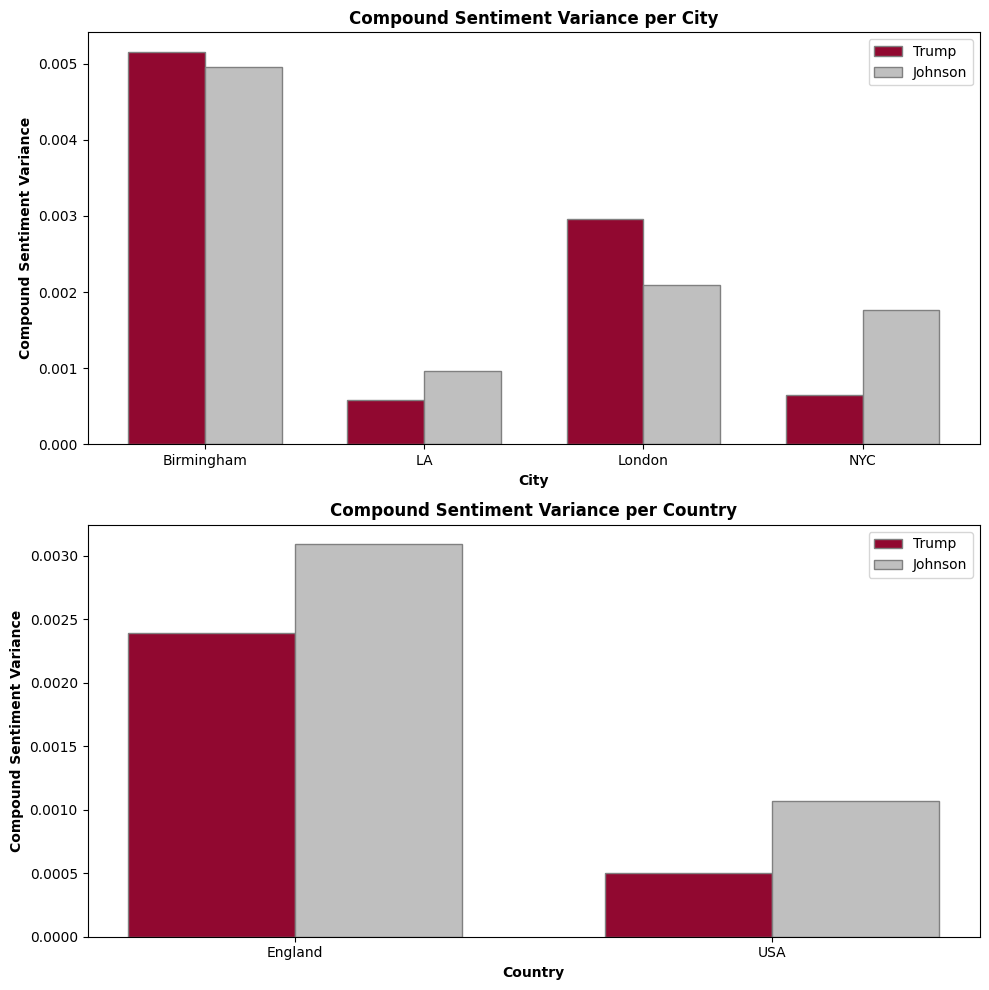

In [15]:
# Create figure and axis
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Set the bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(trump_compound_sentiment_var))
r2 = [x + bar_width for x in r1]

# Make the plot for cities
ax[0].bar(r1, trump_compound_sentiment_var.values, color=colors[0], width=bar_width, edgecolor='grey', label='Trump')
ax[0].bar(r2, johnson_compound_sentiment_var.values, color=colors[1], width=bar_width, edgecolor='grey', label='Johnson')

# Add labels and title for the cities subplot
ax[0].set_xlabel('City', fontweight='bold')
ax[0].set_ylabel('Compound Sentiment Variance', fontweight='bold')
ax[0].set_title('Compound Sentiment Variance per City', fontweight='bold')
ax[0].set_xticks([r + bar_width / 2 for r in range(len(trump_compound_sentiment_var))])
ax[0].set_xticklabels(trump_compound_sentiment_var.index)
ax[0].legend()

# Make the plot for countries
# Set position of bar on X axis for countries
r3 = np.arange(len(trump_compound_sentiment_countries_var))
r4 = [x + bar_width for x in r3]

# Make the plot for countries
ax[1].bar(r3, trump_compound_sentiment_countries_var.values, color=colors[0], width=bar_width, edgecolor='grey', label='Trump')
ax[1].bar(r4, johnson_compound_sentiment_countries_var.values, color=colors[1], width=bar_width, edgecolor='grey', label='Johnson')

# Add labels and title for the countries subplot
ax[1].set_xlabel('Country', fontweight='bold')
ax[1].set_ylabel('Compound Sentiment Variance', fontweight='bold')
ax[1].set_title('Compound Sentiment Variance per Country', fontweight='bold')
ax[1].set_xticks([r + bar_width / 2 for r in range(len(trump_compound_sentiment_countries_var))])
ax[1].set_xticklabels(trump_compound_sentiment_countries_var.index)
ax[1].legend()

# Show the figure
plt.tight_layout()
plt.show()

In [49]:
def plot_sentiment_with_highlights_and_timeframes(data, title, significant_points, timeframe=None, save_path=None):
    plt.figure(figsize=(15, 8))

    # Ensuring enough colors for the cities
    city_colors = colors[:len(data.columns)] if len(colors) >= len(data.columns) else colors

    # Plotting each city's sentiment over time with specific colors and highlighting specific points
    for i, city in enumerate(data.index):
        city_data = data.loc[city].dropna()
        sns.lineplot(x=city_data.index, y=city_data.values, label=city, color=city_colors[i])
        if city in significant_points:
            for date in significant_points[city]:
                if date in city_data.index:
                    plt.scatter(date, city_data[date], color=city_colors[i], s=50, marker='o')

    # Highlighting the specific timeframe with an orange background
    if timeframe:
        start_date, end_date = timeframe
        plt.axvspan(start_date, end_date, color='orange', alpha=0.1)

    # Adding a horizontal line at compound sentiment 0
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Compound Sentiment Score')

    # Adjusting x-axis to display only the years
    plt.xticks([date for date in data.columns if date.endswith("-01")], 
               [date[:4] for date in data.columns if date.endswith("-01")])

    plt.legend(title='City')
    plt.tight_layout()
    # Save the figure to a file if a save path is provided
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
    plt.show()


In [50]:
trump_significant_points = {
    'Birmingham': ['2019-10', '2021-05'],
    'London': ['2021-05']
}
johnson_significant_points = {
    'Birmingham': ['2020-08', '2022-04', '2020-04', '2021-02'],
    'NYC': ['2019-12']
}

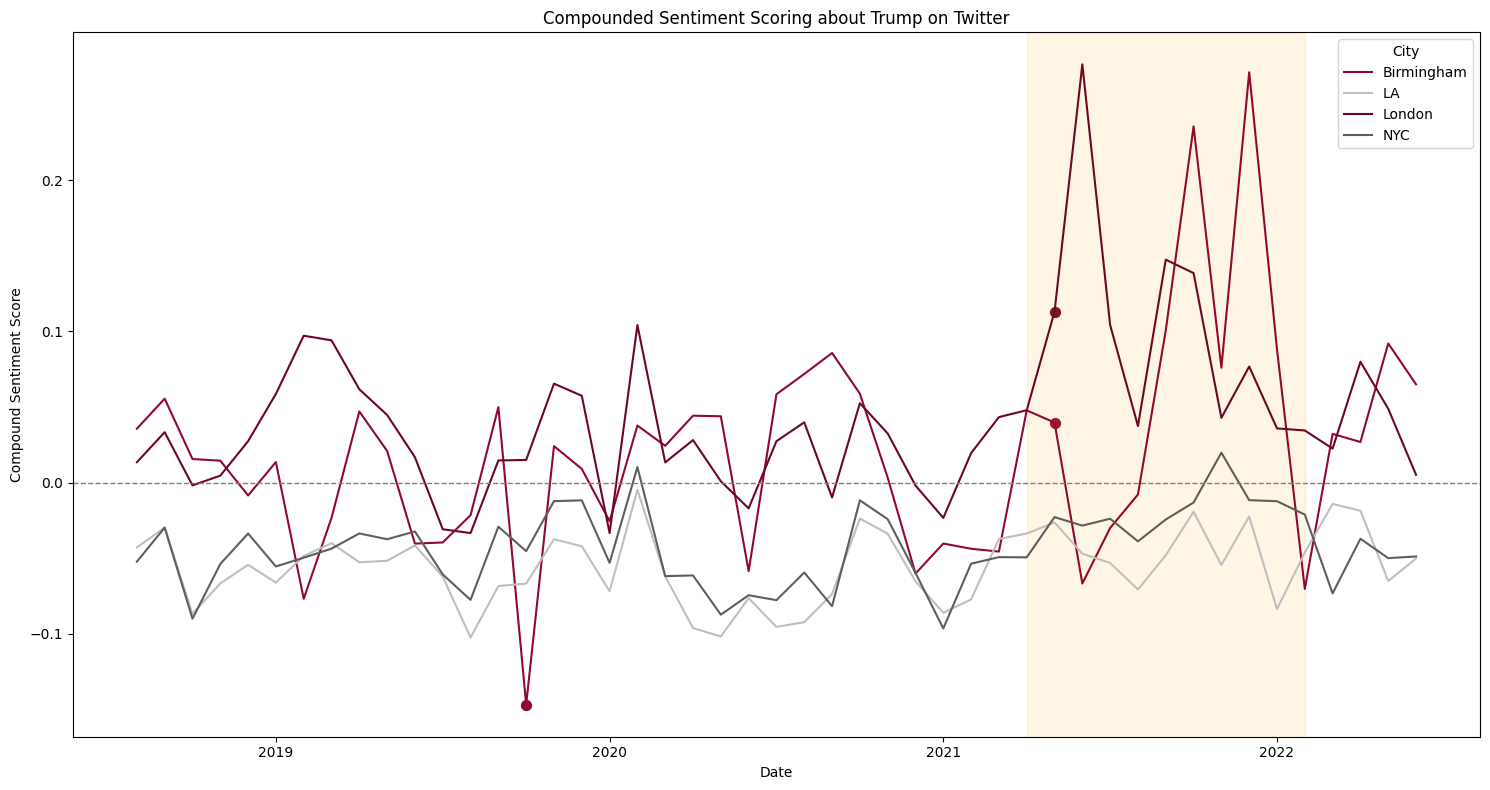

In [55]:
president = presidents[0]
plot_sentiment_with_highlights_and_timeframes(
    data=trump_compound_sentiment, 
    title=f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter', 
    significant_points=trump_significant_points, 
    timeframe=('2021-04', '2022-02'), 
    save_path=f'visualizations/compounded_sentiment_scoring_{president}-cities.png')

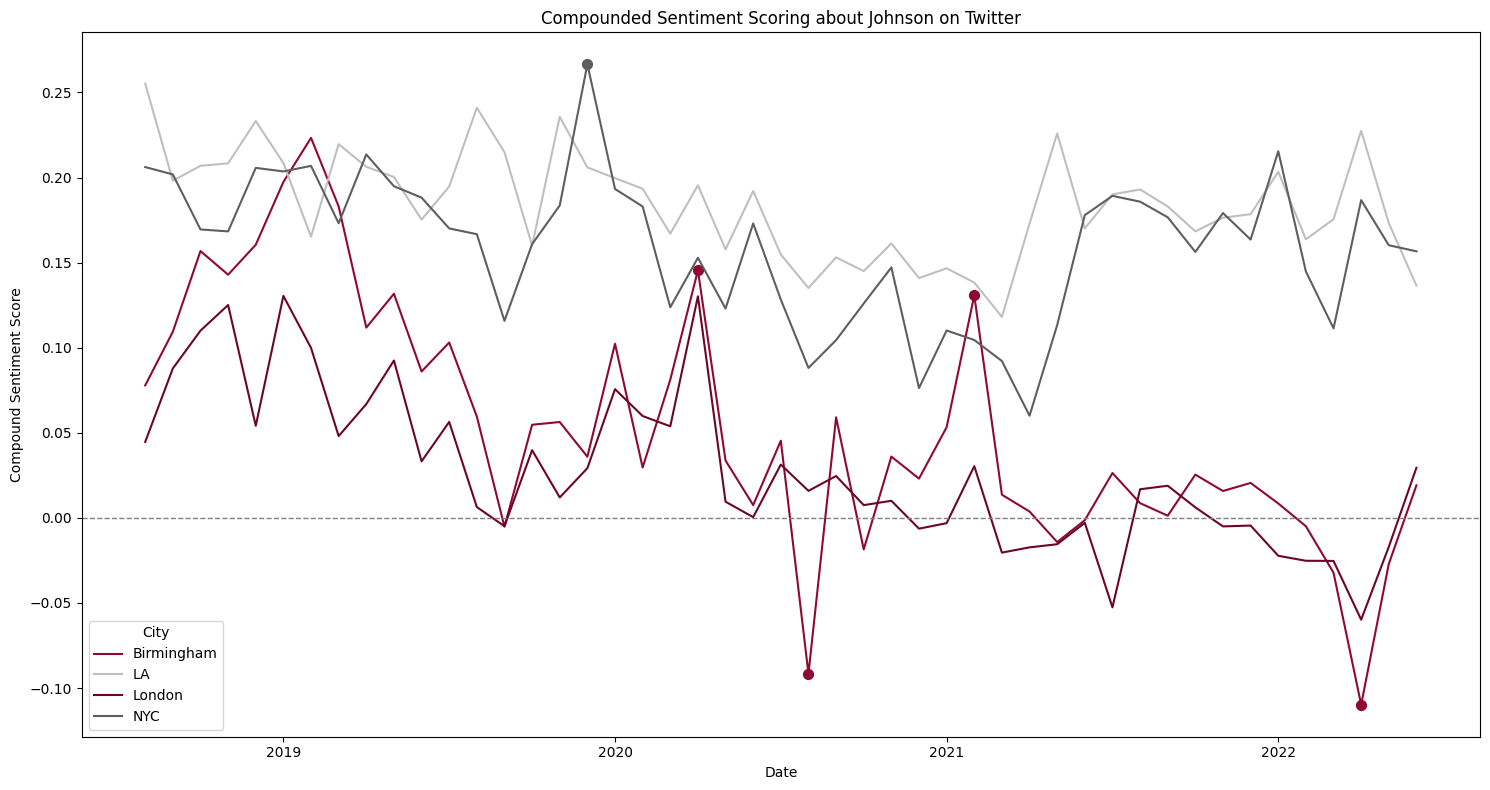

In [54]:
president = presidents[1]
plot_sentiment_with_highlights_and_timeframes(
    data=johnson_compound_sentiment, 
    title=f'Compounded Sentiment Scoring about {president.capitalize()} on Twitter', 
    significant_points=johnson_significant_points,
    save_path=f'visualizations/compounded_sentiment_scoring_{president}-cities.png')

In [20]:
print("trump compound sentiment variance per city")
print(trump_compound_sentiment_var)
print("johnson compound sentiment variance per city")
print(johnson_compound_sentiment_var)
print("trump compound sentiment variance per county")
print(trump_compound_sentiment_countries_var)
print("johnson compound sentiment variance per county")
print(johnson_compound_sentiment_countries_var)

trump compound sentiment variance per city
Birmingham    0.005154
LA            0.000585
London        0.002965
NYC           0.000651
dtype: float64
johnson compound sentiment variance per city
Birmingham    0.004952
LA            0.000957
London        0.002091
NYC           0.001759
dtype: float64
trump compound sentiment variance per county
England    0.002391
USA        0.000504
dtype: float64
johnson compound sentiment variance per county
England    0.003087
USA        0.001065
dtype: float64
